# 1-2、图片数据建模流程示例
## 一、准备数据
cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。训练集有airplane和automobile图像各5000张，测试机有airplane和automobile图像各1000张。
cifar2任务的目的是训练一个模型来对飞机airplane和机动车automobile两种物体进行分类。
我们准备的cifar2数据集的文件结构如下所示。
![]("./data/cifar2.jpg")


在tensorflow中准备图片数据的常用方案有两种，第一种是使用tf.keras中的ImageDataGenerator工具构建图像数据生成器。
第二种是使用tf.data.Dataset搭配tf.image中的一些图片处理方法构建数据管道。
第一种方法更为简单，其使用范例大家可以参考以下文章。
https://zhuanlan.zhihu.com/p/67466552
第二种方案是Tensorflow的原生方法，更加灵活，使用得到的话也可以活得更好的性能。
我们此处介绍第二种方法。

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
BATCH_SIZE=100

def load_image(img_path,size=(32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img,size)/255.0
    return (img,label)

In [2]:
#使用并行化预处理num_parallel_calls和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg")\
                                    .map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                                    .shuffle(buffer_size=1000).batch(BATCH_SIZE)\
                                    .prefetch(tf.data.experimental.AUTOTUNE)

ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

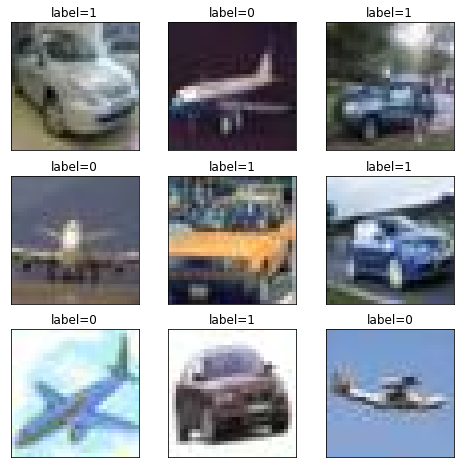

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax = plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label=%d"%(label))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [4]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


## 二、定义模型
使用keras结构有以下三种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型

此处选择使用函数式API构建模型。

In [5]:
tf.keras.backend.clear_session()#清空会话
inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation='sigmoid')(x)

model = models.Model(inputs = inputs,outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

## 三、训练模型
训练模型通常有三种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

In [7]:
import datetime
import os

logdir = os.path.join("./data/keras_model/",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

model.compile(optimizer="adam",
             loss = tf.keras.losses.binary_crossentropy,
             metrics=["AUC"])

In [9]:
history = model.fit(ds_train,epochs=10,validation_data=ds_test,
                   callbacks=[tensorboard_callback],workers=4)

Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 [==============================] - 4s 40ms/step - loss: 0.4261 - AUC: 0.8845 - val_loss: 0.3234 - val_AUC: 0.9446
Epoch 2/10
100/100 [==============================] - 3s 30ms/step - loss: 0.3186 - AUC: 0.9375 - val_loss: 0.2669 - val_AUC: 0.9628
Epoch 3/10
100/100 [==============================] - 3s 30ms/step - loss: 0.2610 - AUC: 0.9589 - val_loss: 0.2230 - val_AUC: 0.9707
Epoch 4/10
100/100 [==============================] - 3s 30ms/step - loss: 0.2211 - AUC: 0.9704 - val_loss: 0.1964 - val_AUC: 0.9787
Epoch 5/10
100/100 [==============================] - 3s 30ms/step - loss: 0.1956 - AUC: 0.9769 - val_loss: 0.1970 - val_AUC: 0.9770
Epoch 6/10
100/100 [==============================] - 3s 30ms/step - loss: 0.1691 - AUC: 0.9827 - val_loss: 0.1779 - val_AUC: 0.9829
Epoch 7/10
100/100 [==============================] - 3s 30ms/step - loss: 0.1488 - AUC: 0.9866 - val_loss: 0.1743 - val_AUC: 0.9824
Epoch 8/10
100/100 [======

## 四、评估模型

In [10]:
%load_ext tensorboard

In [11]:
from tensorboard import notebook
notebook.list()

No known TensorBoard instances running.


In [12]:
notebook.start("--logdir ./data/keras_model/")

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [14]:
import pandas as pd
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory)+1)
dfhistory.index.name = 'epoch'
dfhistory

,loss,AUC,val_loss,val_AUC
epoch,,,,
1,0.426144,0.884508,0.323362,0.944608
2,0.318562,0.937483,0.266927,0.962808
3,0.261010,0.958925,0.222976,0.970661
4,0.221087,0.970440,0.196356,0.978658
5,0.195635,0.976907,0.197005,0.977044
6,0.169133,0.982714,0.177860,0.982908
7,0.148824,0.986601,0.174262,0.982408
8,0.133644,0.989102,0.163117,0.985066
9,0.114217,0.992308,0.149806,0.986091


In [19]:
def plot_metric(history,metric):
    train_metrics = history.history[metric]
    val_metrics = history.history["val_"+metric]
    epochs = range(1,len(train_metrics)+1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

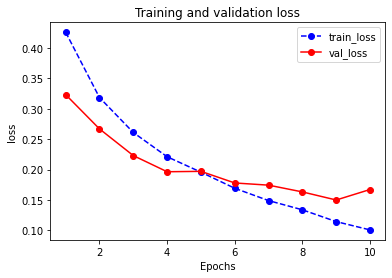

In [20]:
plot_metric(history,"loss")

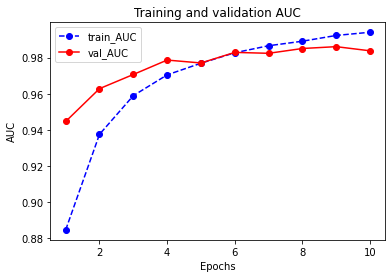

In [21]:
plot_metric(history,"AUC")

In [22]:
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 0s 9ms/step - loss: 0.1671 - AUC: 0.9838
0.16709309555590152 0.9837899


In [23]:
model.predict(ds_test)

array([[1.8348315e-05],
       [9.9956030e-01],
       [9.7876954e-01],
       ...,
       [9.9968994e-01],
       [7.4838027e-02],
       [4.7226395e-02]], dtype=float32)

## 六、保存模型
推荐使用Tensorflow原生方式保存模型

In [24]:
model.save_weights("./data/tf_cifar2_weights.ckpt",save_format="tf")

In [25]:
model.save("./data/tf_cifar_model_savemodel",save_format="tf")
print("model saved")
del model
model_loaded = tf.keras.models.load_model("./data/tf_cifar_model_savemodel")
model_loaded.evaluate(ds_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/tf_cifar_model_savemodel/assets
model saved
20/20 [==============================] - 1s 27ms/step - loss: 0.1671 - AUC: 0.9838


[0.1670926719903946, 0.9837899]